In [15]:
import pandas as pd
import numpy as np
import networkx as nx
from itertools import combinations
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from community import community_louvain
import random

In [ ]:
# download data from Dropbox into the data dir (link to dropbox folder below)
# https://www.dropbox.com/scl/fo/7g2qe67xlxczsmejodcnw/h?dl=0&rlkey=u2jgk7ethlaafa03k0szzfafz

In [16]:
def read_allegations_ipm():
    dfa = pd.read_csv("../data/cprr_new_orleans_pd_1931_2020.csv")
    dfb = pd.read_csv("../data/pprr_new_orleans_pd_1946_2018.csv")
    
    df = pd.merge(dfa, dfb, on="officer_primary_key")
    return df

df_allegation_ipm = read_allegations_ipm()

df_allegation_ipm = df_allegation_ipm.rename(columns={"pib_control_number": "tracking_id"})

df_allegation_ipm.loc[:, "disposition"] = (df_allegation_ipm.disposition
                                                            .str.lower()
                                                            .str.replace(r"resigned(.+)", "sustained", regex=True))

df_allegation_ipm = df_allegation_ipm[df_allegation_ipm.disposition.isin(["sustained"])]

df_allegation_ipm = df_allegation_ipm[["tracking_id", "uid"]]

In [17]:
def read_allegations_da():
    df = pd.read_csv("../data/cprr_new_orleans_da_2016_2020.csv")
    return df

df_allegation_da = read_allegations_da()

df_allegation_da.loc[:, "disposition"] = (df_allegation_da.disposition 
                                                          .str.replace(r"(.+)?sustained(.+)?", "sustained", regex=True))

df_allegation_da = df_allegation_da[df_allegation_da.disposition.isin(["sustained"])]

df_allegation_da = df_allegation_da[["tracking_id", "uid"]]

In [18]:
def read_uof():
    df = pd.read_csv("../data/uof_new_orleans_pd_2016_2022.csv")
    return df

df_uof = read_uof() 

df_uof = df_uof[["tracking_id", "uid"]] 

In [19]:
def read_sas():
    df = pd.read_csv("../data/sas_new_orleans_pd_2010_2021.csv")
    return df

df_sas = read_sas()

df_sas = df_sas[["tracking_id", "uid"]]

C:\Users\PC\AppData\Local\Temp\ipykernel_14424\240441886.py:2: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/sas_new_orleans_pd_2010_2021.csv")


In [20]:
def read_pr():
    df = pd.read_csv("../data/pr_new_orleans_pd_2010_2022.csv")
    return df

df_epr = read_pr()

df_epr = df_epr.rename(columns={"item_number": "tracking_id"})

df_epr = df_epr[["tracking_id", "uid"]]

C:\Users\PC\AppData\Local\Temp\ipykernel_14424\1936087320.py:2: DtypeWarning: Columns (23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/pr_new_orleans_pd_2010_2022.csv")


In [21]:
# remove outliers 
df_allegation_ipm = df_allegation_ipm[~df_allegation_ipm.tracking_id.isin(df_allegation_ipm.tracking_id.value_counts().loc[lambda x: x >= 30 ].index)]
df_allegation_da = df_allegation_da[~df_allegation_da.tracking_id.isin(df_allegation_da.tracking_id.value_counts().loc[lambda x: x >= 30 ].index)]

df_uof = df_uof[~df_uof.tracking_id.isin(df_uof.tracking_id.value_counts().loc[lambda x: x >= 30 ].index)]
df_sas = df_sas[~df_sas.tracking_id.isin(df_sas.tracking_id.value_counts().loc[lambda x: x >= 30 ].index)]
df_epr = df_epr[~df_epr.tracking_id.isin(df_epr.tracking_id.value_counts().loc[lambda x: x >= 30 ].index)]

In [22]:
# filter out officers not in the allegation table
df = pd.concat([df_allegation_ipm, df_allegation_da])

df_uof = df_uof[df_uof['uid'].isin(df['uid'])]
df_sas = df_sas[df_sas['uid'].isin(df['uid'])]
df_epr = df_epr[df_epr['uid'].isin(df['uid'])]

In [23]:
df = pd.concat([df, df_uof, df_sas, df_epr])

In [24]:
dfa = df.groupby('tracking_id').count()
dfb = dfa[dfa.uid > 1]

group_complaints = list(set(dfb.index))

df["count"] = 1
df_uid_count = df.drop_duplicates(subset=["tracking_id", "uid"])
df_uid_count = df_uid_count.pivot_table(index=["tracking_id"], values=["count"], aggfunc="sum").reset_index()
df_uid_count = df_uid_count.rename(columns={"count": "no_of_officers_per_tracking_id"})

dict_per_complaint = dict(zip(df_uid_count.tracking_id, df_uid_count.no_of_officers_per_tracking_id))

g = nx.Graph()
for incident in group_complaints:
    tracking_id = dict_per_complaint.get(incident)
    node_pairs = list(combinations(df[df.tracking_id == incident]['uid'].tolist(), 2))
    for node_pair in node_pairs:
        if g.has_edge(node_pair[0], node_pair[1]):
            g[node_pair[0]][node_pair[1]]['weight'] += (1+1/tracking_id)
        else:
            g.add_edge(node_pair[0], node_pair[1], weight = (1+1/tracking_id))

edge_list = list(g.edges)

remove_edge_list = [nodes for nodes in edge_list if g[nodes[0]][nodes[1]]['weight'] <=2]
g.remove_edges_from(remove_edge_list)
g.remove_nodes_from(list(nx.isolates(g)))

In [25]:
with open("output/edge_list.txt", "wb") as f:
    nx.write_edgelist(g, f)

In [26]:
comms = community_louvain.best_partition(g, randomize=0)

In [27]:
unique_coms = np.unique(list(comms.values()))
unique_coms

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

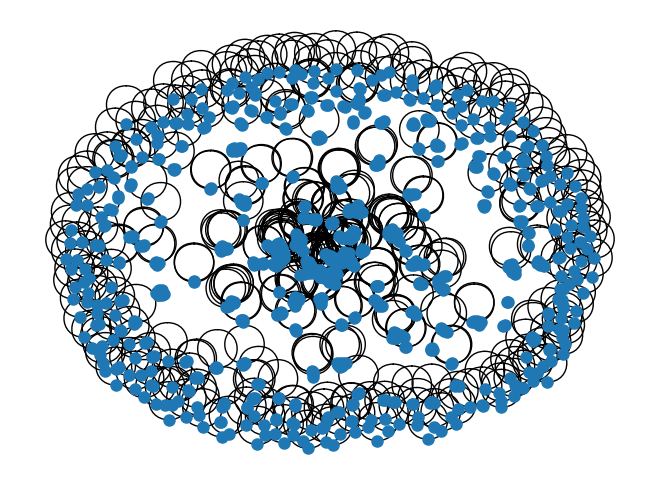

In [28]:
pos = nx.spring_layout(g)
nx.draw(g, pos, node_size = 64, alpha = 1)
plt.show()

In [32]:
comm_df = pd.DataFrame.from_dict(comms, orient="index").reset_index()
comm_df = comm_df.rename(columns={comm_df.columns[1]: "community", "index": "uid"})
comm_df

,uid,community
0,5826615ba30b2ecab5739fa177b4819e,0
1,146e167efb7a3acc83eeeff513ccfa5f,0
2,6fdd9bfce56a8a5d5dd2cb64fab77316,0
3,ce959f622671394b9ee0f7b867d8f441,1
4,fc5fcbe2332c6b7db093cb17f4eb76e4,2
...,...,...
827,871123b7c3ab1ae71af519ded3f25f06,164
828,ed609fda9dcdc9ee6482794b3f5a8e13,359
829,2a3df1d9351ee1f28feadfbe3b4108a5,79
830,6c75dc909b00e416e4c17fb0ddd76977,79


In [34]:
comm_df = comm_df.groupby("community").filter(lambda x:  len(x)>1)

comm_df.community.value_counts().sort_values(ascending=False)

36     27
89     18
30     17
16     17
12     13
       ..
320     2
314     2
311     2
283     2
79      2
Name: community, Length: 171, dtype: int64